In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import kagglehub
path=kagglehub.dataset_download("abenjelloun/breast-mri-tumor-classification-dataset")
print("Path to dataset files:",path)

Path to dataset files: /kaggle/input/breast-mri-tumor-classification-dataset


In [2]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="1.00" 
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"   
os.environ["TF_GPU_THREAD_MODE"]="gpu_private"  
os.environ["TF_XLA_FLAGS"]="--tf_xla_enable_xla_devices"

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_path='/kaggle/input/breast-mri-tumor-classification-dataset/breast_mri_dataset/train'
test_path='/kaggle/input/breast-mri-tumor-classification-dataset/breast_mri_dataset/test'
val_path='/kaggle/input/breast-mri-tumor-classification-dataset/breast_mri_dataset/val'

2025-07-28 16:30:15.532660: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753720215.712384      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753720215.765349      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30,
    fill_mode='nearest'
)

In [5]:
val_test_datagen=ImageDataGenerator(
    rescale=1./255,
)

In [6]:
train_data=train_datagen.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=64,
    shuffle=True,
    color_mode='rgb',
    class_mode='binary'
)

Found 16826 images belonging to 2 classes.


In [7]:
test_data=val_test_datagen.flow_from_directory(
    test_path,
    target_size=(224,224),
    batch_size=64,
    shuffle=False,
    color_mode='rgb',
    class_mode='binary'
)

Found 3604 images belonging to 2 classes.


In [8]:
val_data=val_test_datagen.flow_from_directory(
    val_path,
    target_size=(224,224),
    batch_size=64,
    shuffle=False,
    color_mode='rgb',
    class_mode='binary'
)

Found 3594 images belonging to 2 classes.


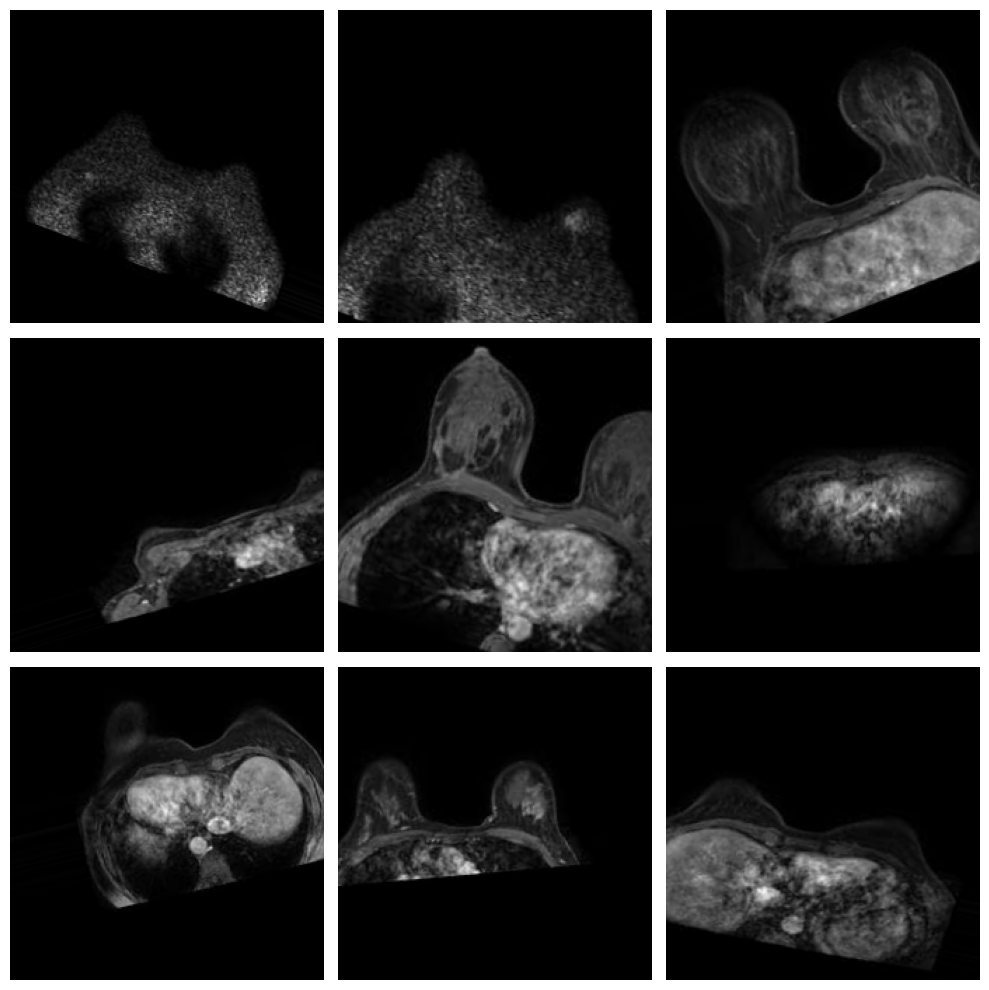

In [9]:
import matplotlib.pyplot as plt
sample_images,sample_labels=next(train_data)
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(sample_images[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [10]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
class_weights=compute_class_weight(class_weight='balanced',classes=np.unique(train_data.classes),y=train_data.classes)
class_weights_dict=dict(enumerate(class_weights))

In [11]:
print(class_weights_dict)

{0: 1.0, 1: 1.0}


In [12]:
from tensorflow.keras import layers,models,Model
def conv_mixer_block(x,dim,kernel_size):
    residual=x
    x=layers.DepthwiseConv2D(kernel_size=kernel_size,padding='same',activation='gelu')(x)
    x=layers.BatchNormalization()(x)
    x=layers.Add()([x,residual]) #Residual connection
    #Pointwise convolution block
    x=layers.Conv2D(dim,kernel_size=1,activation='gelu')(x)
    x=layers.BatchNormalization()(x)
    return x

In [13]:
def create_convmixer_model(input_shape=(224,224,3),num_classes=2,dim=256,depth=8,kernel_size=5,patch_size=4):
    inputs=layers.Input(shape=input_shape)
    #Patch embedding
    x=layers.Conv2D(dim,kernel_size=patch_size,strides=patch_size,activation='gelu')(inputs)
    x=layers.BatchNormalization()(x)
    #Stack of ConvMixer blocks
    for i in range(depth):
        x=conv_mixer_block(x,dim,kernel_size)
    #Classification head
    x=layers.GlobalAveragePooling2D()(x)
    outputs=layers.Dense(1,activation='sigmoid')(x)
    return models.Model(inputs,outputs)

In [14]:
model=create_convmixer_model()
model.summary()

I0000 00:00:1753720335.384212      36 service.cc:148] XLA service 0x4245b630 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753720335.384859      36 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1753720335.479644      36 service.cc:148] XLA service 0x4169cfe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753720335.479677      36 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753720335.493733      36 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1753720335.495929      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 56, 56,    │     12,544 │ input_layer[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 56, 56,    │      1,024 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 56, 56,    │      6,656 │ batch_normalizat… │
│ (DepthwiseConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │     65,792 │ add[0][0]         │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_1  │ (None, 56, 56,    │      6,656 │ batch_normalizat… │
│ (DepthwiseConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     65,792 │ add_1[0][0]       │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_2  │ (None, 56, 56,    │      6,656 │ batch_normalizat… │
│ (DepthwiseConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     65,792 │ add_2[0][0]     

 Total params: 609,793 (2.33 MB)

 Trainable params: 601,089 (2.29 MB)

 Non-trainable params: 8,704 (34.00 KB)

In [15]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-4),loss='binary_crossentropy',metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopper=EarlyStopping(patience=5,monitor='val_loss',restore_best_weights=True)

In [17]:
history=model.fit(train_data,validation_data=val_data,epochs=30,batch_size=64,callbacks=[early_stopper],verbose=1,class_weight=class_weights_dict)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1753720364.146029     134 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753720370.363927     134 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


263/263 ━━━━━━━━━━━━━━━━━━━━ 354s 1s/step - accuracy: 0.5701 - loss: 0.6760 - val_accuracy: 0.5000 - val_loss: 0.8669
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 217s 822ms/step - accuracy: 0.6873 - loss: 0.5798 - val_accuracy: 0.5000 - val_loss: 1.2134
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 216s 822ms/step - accuracy: 0.7395 - loss: 0.5149 - val_accuracy: 0.7654 - val_loss: 0.4765
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 215s 815ms/step - accuracy: 0.7794 - loss: 0.4529 - val_accuracy: 0.6681 - val_loss: 0.7153
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 213s 809ms/step - accuracy: 0.8075 - loss: 0.4097 - val_accuracy: 0.7974 - val_loss: 0.4132
Epoch 6/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 210s 795ms/step - accuracy: 0.8276 - loss: 0.3703 - val_accuracy: 0.7738 - val_loss: 0.5182
Epoch 7/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 212s 804ms/step - accuracy: 0.8493 - loss: 0.3331 - val_accuracy: 0.8712 - val_loss: 0.2791
Epoch 8/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 214s 812ms/step - accuracy: 0.8578 - loss: 0.3126 

In [18]:
test_loss,test_accuracy=model.evaluate(test_data,verbose=1)
print(f"\nTest Accuracy:{test_accuracy*100:.4f}%")

57/57 ━━━━━━━━━━━━━━━━━━━━ 32s 566ms/step - accuracy: 0.9783 - loss: 0.0546

Test Accuracy:96.0322%


In [19]:
val_loss,val_accuracy=model.evaluate(val_data,verbose=1)
print(f"\nValidation Accuracy:{val_accuracy*100:.4f}%")

57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9783 - loss: 0.0546

Validation Accuracy:96.6889%


In [20]:
y_pred=model.predict(test_data)
y_pred_class=(y_pred>0.5).astype(int).reshape(-1)
y_true=test_data.classes

57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 181ms/step


In [21]:
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,classification_report,confusion_matrix

accuracy=accuracy_score(y_true,y_pred_class)
precision=precision_score(y_true,y_pred_class,average='weighted',zero_division=1)
recall=recall_score(y_true,y_pred_class,average='weighted')
f1=f1_score(y_true,y_pred_class,average='weighted',zero_division=1)

print("\nPerformance Metrics Breakdown:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Performance Metrics Breakdown:
Accuracy: 0.9603
Precision: 0.9616
Recall: 0.9603
F1-Score: 0.9603


In [22]:
class_labels=list(val_data.class_indices.keys())

In [23]:
print("Classification Report:")
print(classification_report(y_true,y_pred_class,target_names=class_labels,zero_division=1))

Classification Report:
              precision    recall  f1-score   support

      Benign       0.94      0.99      0.96      1802
   Malignant       0.99      0.93      0.96      1802

    accuracy                           0.96      3604
   macro avg       0.96      0.96      0.96      3604
weighted avg       0.96      0.96      0.96      3604

